In [1]:
# Rotation on axis of image 
# Zoom in image 
# Zoom out image 
# clockwise! and counter clock wise rotation
# Noise - Gaussian and Uniform 

# installation inside image
!conda install -y seaborn
!conda install -y  -c menpo opencv



Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /opt/conda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.3.7                |           py35_0         491 KB
    seaborn-0.7.1              |           py35_0         281 KB
    ------------------------------------------------------------
                                           Total:         773 KB

The following NEW packages will be INSTALLED:

    seaborn: 0.7.1-py35_0 

The following packages will be UPDATED:

    conda:   4.2.14-py35_0 --> 4.3.7-py35_0

Fetching packages ...
conda-4.3.7-py 100% |################################| Time: 0:00:00   5.02 MB/s
seaborn-0.7.1- 100% |################################| Time: 0:00:00   4.44 MB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Unlinking

In [6]:
# Import train data.
from PIL import Image
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import seaborn as sns

sns.set_style("white")

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']


validation_file = "test.p"

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
X_valid, y_valid = valid['features'], valid['labels']

In [2]:
import random
from PIL import Image
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

"""
Creates a validation and test set from the given data.
You can specify the gray scale.

Note: Samples are stratified samples.

"""
def create_validation_dataset(X,y,gray=False,prob = 0.3):
    X_validation, X_test, y_validation, y_test = train_test_split(X, y, train_size=prob,stratify=y,random_state=59)
    if gray:
        GRAY = "_gray"
    else:
        GRAY = ""
        
    new_training_file = "test_final"+GRAY+".p"
    new_train = {}
    if not gray:
        new_train['features'] = np.asarray(X_test)
    else:
        new_train['features'] = np.asarray(gray_scale(X_test) )
    new_train['labels'] = y_test
    pickle.dump( new_train, open( new_training_file, "wb" ) )
    
    new_training_file = "validation"+GRAY+".p"
    new_train = {}
    if not gray:
        new_train['features'] = np.asarray(X_validation)
    else:
        new_train['features'] = np.asarray(gray_scale(X_validation) )
    new_train['labels'] = y_validation
    pickle.dump( new_train, open( new_training_file, "wb" ) )
    

"""
Converts the array of images into gray scale images

"""
def gray_scale(X):
    X_gray = []
    for each in X:
        #print(np.shape(each))
        gray_image = np.asarray(cv2.cvtColor(each, cv2.COLOR_RGB2GRAY))
        #print(type(gray_image))
        X_gray.append(np.expand_dims(gray_image,axis=2))
    #plt.imshow(X_gray[0])
    return X_gray


# Rotation of image 
"""
Rotate the image clockwise and counter clock wise. [-6,-4,-2,0,2,4,6]
6 images per image.

"""
def image_rotation(X,y):
    rot_X = []
    rot_y = []
    for ex,ey in zip(X,y):
        img = Image.fromarray(ex)
        
        i = random.randrange(-10,10)
        im2 = img.convert('RGBA')
        new_image = im2.rotate(i)
        # a white image same size as rotated image
        blank_img = Image.new('RGBA', (32,32), (255,)*4)
        # create a composite image using the alpha layer of rot as a mask
        out = Image.composite(new_image, blank_img, new_image)
        out.convert('RGB')
        rot_X.append(np.asarray(out))
        rot_y.append(ey)
    return rot_X,rot_y
"""
Blur the image with a kernel of 5x5

"""
def image_blur(X,y,kernel_size=5):
    blur_X =[]
    blur_y = []
    for ex,ey in zip(X,y):
        #kernel = np.ones((kernel_size,kernel_size),np.float32)/25
        blr_img = cv2.GaussianBlur(ex,(kernel_size,kernel_size),0)
        #blr_img = cv2.filter2D(ex,-1,kernel)
        blur_X.append(blr_img)
        blur_y.append(ey)
    return blur_X,blur_y

def noisy_data(X,y):
    row,col,ch = np.shape(X[0])
    noisy_X = []
    noisy_y = []
    for ex,ey in zip(X,y):
        noisy_image = np.asarray(
                        np.random.uniform(
                        -5,5,(row,col,ch))
                    ,dtype=np.uint8)+ex
               
        noisy_X.append(noisy_image)
        noisy_y.append(ey)
    return noisy_X,noisy_y

"""
Contrast Increase using HSV values.
"""
def contrast_increase_data(X,y,value=5):
    row,col,ch = np.shape(X[0])
    contra_X = []
    contra_y = []
    for ex,ey in zip(X,y):
        #contra_image = np.array(cv2.cvtColor(ex,cv2.COLOR_RGB2YUV),dtype=np.float32)
        
        im2 = cv2.cvtColor(ex, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        X_ = clahe.apply(im2)      
        print(np.shape(X_))
               
        contra_X.append(X_)
        contra_y.append(ey)
    return contra_X,contra_y


def transform_data(X,y,count=1000):
    ang_range = 20
    trans_range = 10
    shear_range = 5
    X_new = []
    y_new = []
    for ex,ey in zip(X,y):
        ang_rot = np.random.uniform(ang_range)-ang_range/2
        rows,cols,ch = np.shape(ex)    
        Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
        
        tr_x = trans_range*np.random.uniform()-trans_range/2
        tr_y = trans_range*np.random.uniform()-trans_range/2
        Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

        pts1 = np.float32([[5,5],[20,5],[5,20]])

        pt1 = 5+shear_range*np.random.uniform()-shear_range/2
        pt2 = 20+shear_range*np.random.uniform()-shear_range/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

        shear_M = cv2.getAffineTransform(pts1,pts2)
        img = cv2.warpAffine(ex,Rot_M,(cols,rows))
        img = cv2.warpAffine(img,Trans_M,(cols,rows))
        img = cv2.warpAffine(img,shear_M,(cols,rows))
        X_new.append(img)
        y_new.append(ey)
    return X_new,y_new

In [3]:
sns.distplot(y_train,kde=False);

NameError: name 'sns' is not defined

In [4]:
import pandas as pd
data = pd.read_csv("./signnames.csv")

In [5]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [ ]:
label_series = pd.Series(y_train)

In [ ]:
label_values = label_series.value_counts()

In [ ]:
[]

In [9]:


"""
Plots the variations in the diagrams
"""
def plot_variations(X,X_orig,y_train, sign_name,num_var,num_examples = 5 ): 
    fig, axes = plt.subplots(nrows=num_examples, ncols=num_var+1)
    index_list = []
    sign_name_list =[]
    pad = 5 # in points

    for j in range(1,num_examples+1) :
        y_index = random.randint(0,len(y_train))
        index_list.append(y_index)
        sign_name_list.append(sign_name[y_train[y_index]])
    
    ax_lbls = axes[:,0]
    for ax, row in zip(ax_lbls, sign_name_list):
        ax.annotate(row.replace(" ","\n"), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='small', ha='right', va='center')
        #ax.set_ylabel(row.replace(" ","\n"), rotation=0, size='small')  
    
    for j in range(1,num_examples+1) :
        y_index = index_list[j-1]
        image_index = y_index*num_var
        
        
        ax1 = axes[j-1,0]
        #ax1 = plt.subplot(num_examples,num_var,k)
        ax1.imshow(X_orig[y_index])
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])
        for i in range(1,num_var +1):
            k = (num_var*(j-1))+i
            im_index = int(str(num_examples)+str(num_var)+str(k))
            
            ax1 = axes[j-1,i]
            #ax1 = plt.subplot(num_examples,num_var,k)
            ax1.imshow(X[image_index+i-1])
            ax1.get_xaxis().set_ticks([])
            ax1.get_yaxis().set_ticks([])
          
    #ax1.set_ylabel(sign_name[y_train[y_index]], rotation=0, size='small')
    fig.tight_layout()

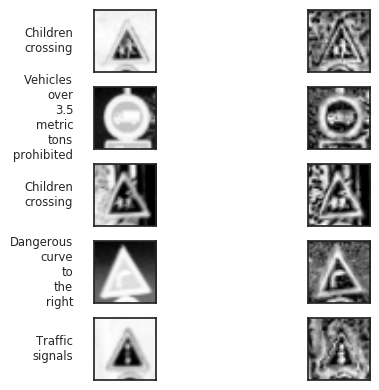

In [13]:
sign_name = list(data.SignName)
X_rot,y_rot = contrast_increase_data(X_train,y_train,value=200)
X_new = X_rot
X_train_gray = np.reshape(gray_scale(X_train),(len(X_train),32,32))
plot_variations(np.reshape(X_new,(len(X_new),32,32)),X_train_gray,y_train,sign_name,1,5)
#X_blr,y_blr = image_blur(X_train,y_train,kernel_size=3)
#plot_variations(X_blr,y_train,sign_name,1,3)
#X_noise,y_noise = noisy_data(X_train,y_train)
#plot_variations(X_noise,X_train,y_train,sign_name,1,4)

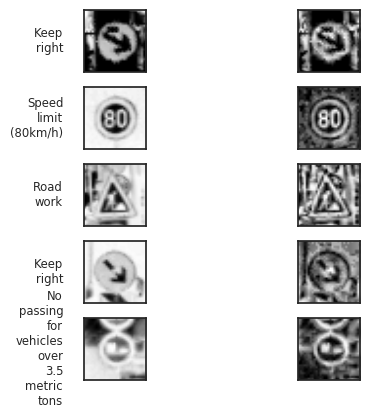

In [25]:
plot_variations(np.reshape(X_new,(len(X_new),32,32)),X_train_gray,y_train,sign_name,1,5)


In [ ]:
?plt.axes

In [ ]:
# Human Level Error 1%
# Training error 6%
# Validation set error 5%
# Much less than human error . High Bias in the data 
    # Train bigger model, More data
    
# Human Level Error 1%
# Training error 2%
# Validation set error 6%
# Much less than human error . High Varriance in the data (Overfitting)
    # Regulariser, early stopping, More data

# Human Level Error 1%
# Training error 5%
# Validation set error 10%
# High bias and hig varriance 
    #

In [ ]:
img = X_valid[0]
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
plt.imshow(img)
plt.show()
plt.imshow(img_output)

In [ ]:

X_rot,y_rot = image_blur(X_train,y_train,kernel_size=3)
X_train_contra,y_train_contra = contrast_increase_data(np.asarray(X_rot),y_rot,value=200)

X_new = X_train_contra

X_rot_1,y_rot_1 = image_rotation(X_train,y_train)

X_gray,y_gray = contrast_increase_data(np.asarray(X_rot_1),y_rot_1,value=200)
X_new_gray = X_gray


X_latest = np.concatenate((X_new_gray,X_new),axis=0)
y_latest = np.concatenate((y_gray,y_train),axis=0)

X_cont,y_cont = contrast_increase_data(X_valid,y_valid,value=200)
X_valid_new = X_cont
X_valid_gray = np.reshape(gray_scale(X_cont),(len(X_cont),32,32))

In [ ]:
for i in range(5):
    X_aff,y_aff = transform_data(X_train,y_train)
    X_aff_new = gray_scale(X_aff)
    X_latest =np.concatenate((X_latest,X_aff_new),axis=0)
    y_latest =np.concatenate((y_latest,y_aff),axis=0)


In [ ]:
new_training_file = "train_gray_blur_contrast_rot_final.p"
new_train = {}
new_train['features'] = np.asarray(X_latest) 
new_train['labels'] = y_latest
pickle.dump( new_train, open( new_training_file, "wb" ) )

In [ ]:
new_training_file = "validation_gray_contrast.p"
new_train = {}
new_train['features'] = np.asarray(X_valid_new) 
new_train['labels'] = y_valid
pickle.dump( new_train, open( new_training_file, "wb" ) )

In [ ]:
random.randrange(-10,10)

In [ ]:

def transform_image(X,y):
    ang_range = 20
    trans_range = 10
    shear_range = 5
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = np.shape(X)   
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(X,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    
    
    return img,y

In [ ]:
MIN_CLASS_LEN=2000
X_final = []
y_final = []
for i in range(43):
    indexes = np.where(y_train==i)
    idx = np.reshape(indexes, (np.shape(indexes)[1]))
    len_class = np.shape(indexes)[1]
    X_class = X_train[idx]
    #print(np.shape(X_class))
    #plt.imshow(X_class[0],cmap="gray")
    y_class = np.asarray(y_train)[idx]
    X_class_new = np.asarray(np.copy(X_class))
    y_class_new = np.copy(y_class)
    if(len_class<MIN_CLASS_LEN):
        #print(len_class)
        for i in range(0,MIN_CLASS_LEN-len_class):
            index = random.randint(0,len_class-1)
            new_image,y = transform_image(X_class[index],y_class[index])
            X_final.append(new_image)
            #print(y)
            
            y_final.append(y)
    
    for ex,ey in zip(X_class_new,y_class_new):
        X_final.append(ex)        
        y_final.append(ey)
    print(len(y_final))
    
        

In [ ]:
plt.hist(y_final,bins=range(0,42))

In [ ]:
X_gray_contrast_final,y_f = contrast_increase_data(X_final,y_final)
X_final_gray = X_gray_contrast_final


In [ ]:
plot_variations(np.reshape(X_final_gray,(len(X_final_gray),32,32)),np.reshape(X_train_contra_new,(len(X_train_contra_new),32,32)),y_train,sign_name,1,5)


In [ ]:
new_training_file = "train_gray_balanced_contrast.p"
new_train = {}
new_train['features'] = np.expand_dims(np.asarray(X_final_gray) ,axis=3)
new_train['labels'] = y_final
pickle.dump( new_train, open( new_training_file, "wb" ) )

In [12]:
new_training_file = "test_gray_contrast.p"
new_train = {}
X_valid_cont,y_valid_cont = contrast_increase_data(X_valid,y_valid)
new_train['features'] = np.expand_dims(np.asarray(X_valid_cont),axis=3)
new_train['labels'] =  y_valid_cont
# = y_valid
pickle.dump( new_train, open( new_training_file, "wb" ) )


# new_training_file = "validation_gray_balanced.p"
# new_train = {}
# new_train['features'] = np.asarray(gray_scale(X_valid)) 
# new_train['labels'] = y_valid
# pickle.dump( new_train, open( new_training_file, "wb" ) )

In [ ]:
im2 = Image.fromarray(img).convert('RGBA')
blank_img = Image.new('RGBA', (32,32), (0,)*4)
# create a composite image using the alpha layer of rot as a mask
out = Image.composite(im2, blank_img, im2)
out = out.convert('RGB')

In [ ]:
plt.imshow(out)

In [ ]:
#!source activate CarND-TensorFlow-Lab ;pip install imblearn
from imblearn.over_sampling import RandomOverSampler


In [ ]:
#Per classs augmentation
X_new = []
y_new = []

#transform_image(image,20,10,5,brightness=1)
# X_rot,y_rot = image_blur(X_train,y_train,kernel_size=3)
X_train_contra,y_train_contra = contrast_increase_data(np.asarray(X_train),y_train,value=200)
X_train_contra_new = np.asarray(gray_scale(np.asarray(X_train_contra)))
X_new = X_train_contra_new

#X_rot_1,y_rot_1 = image_rotation(X_train,y_train)

#X_gray,y_gray = contrast_increase_data(np.asarray(X_rot_1),y_rot_1,value=200)
#X_new_gray = gray_scale(X_gray)



X_latest = X_new#np.concatenate((X_new_gray,X_new),axis=0)
y_latest = y_train#np.concatenate((y_gray,y_train),axis=0)
X_new = X_latest
y_new = y_latest
#plot_variations(np.reshape(X_new,(len(X_new),32,32)),X_train_gray,y_train,sign_name,1,5)


for i in range(43):
    indexes = np.where(y_train==i)
    idx = np.reshape(indexes, (np.shape(indexes)[1]))
    len_class = np.shape(indexes)[1]
    X_class = X_train_contra_new[idx]
    #plt.imshow(X_class[0],cmap="gray")
    y_class = np.asarray(y_train_contra)[idx]
    #X_class_new = gray_scale(X_class)
    X_class_new = np.copy(X_class)
    y_class_new = y_class
    if(len_class<1000):
#         print(len_class)
        count = len_class
        for j in range(1000-len_class):
            X_aff,y_aff = transform_data(X_class,y_class)
            X_aff_new = X_aff
            print(np.shape(X_class_new),np.shape(X_aff_new))
            X_class_new =np.concatenate((X_class_new,np.expand_dims(X_aff_new,axis=3)),axis=0)
            y_class_new =np.concatenate((y_class_new,y_aff),axis=0)
            
            if(len(y_class_new)>1000):
                break
    if(X_new == []):
        X_new = X_class_new
    else:
        X_new = np.concatenate((X_class_new,X_new),axis=0)
    y_new =np.concatenate((y_new,y_class_new),axis=0)
    print(len(y_class_new),i,y_class_new[0])
    print(len(y_new),i)

#     print(np.shape(y_new))

        
    #print(np.shape(X_train[idx]))
    #print(np.shape(indexes))
    

In [ ]:
from itertools import groupby
plt.hist(y_new, bins=range(43))


In [ ]:
new_training_file = "train_equal.p"
new_train = {}
new_train['features'] = np.asarray(X_new) 
new_train['labels'] = y_new
pickle.dump( new_train, open( new_training_file, "wb" ) )

In [ ]:
np.shape(X_new)

In [ ]:
plt.imshow(X_train[0])

In [ ]:
plot_variations(np.reshape(X_new,(len(X_new),32,32)),np.reshape(X_train_contra_new,(len(X_train_contra_new),32,32)),y_train,sign_name,1,5)


In [ ]:
im_idx = random.randint(0,len(np.reshape(X_new,(len(X_new),32,32))))
plt.imshow(np.reshape(X_new,(len(X_new),32,32))[im_idx])
plt.show()
plt.imshow(np.reshape(X_new,(len(X_new),32,32))[im_idx]/255)

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


In [ ]:
im_idx = random.randint(0,len(y_train))
plt.imshow(rgb2gray(X_train[im_idx]))
plt.show()
plt.imshow(rgb2gray(X_train[im_idx])/255)

In [ ]:
img = X_valid[0]
im2 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(im2)
plt.imshow(cl1)
plt.show()

img = X_valid[0]
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
g= cv2.cvtColor(img_output,cv2.COLOR_RGB2GRAY)
plt.imshow(g,cmap="gray")


In [ ]:
img = X_valid[0]
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
plt.imshow(img)
plt.show()
plt.imshow(img_output)

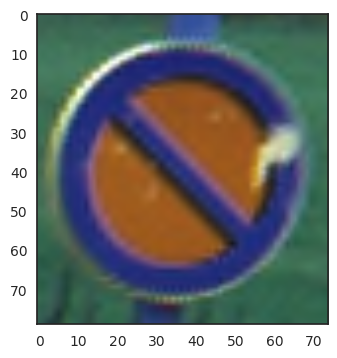

In [53]:
img = cv2.imread("Training/00040/01826_00000.ppm")
plt.imshow(img)

In [55]:
img_small = np.resize(img,(32,32,3))

(43, 40)


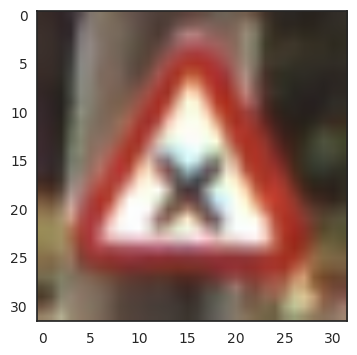

In [74]:
from PIL import Image
img = Image.open("Training/00018/00009_00000.ppm")
print(img.size)
img = img.resize((32, 32), Image.ANTIALIAS)
plt.imshow(img)

In [82]:
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train_gray_balanced_contrast.p"
testing_file = "test_final_gray.p"
validation_file = "validation_gray_balanced.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
# with open(testing_file, mode='rb') as f:
#     test = pickle.load(f)
with open(validation_file, mode='rb') as f:
    validation = pickle.load(f)
    
X_train_old, y_train = train['features'], train['labels']
# X_test, y_test = test['features'], test['labels']
X_validation_old, y_validation = validation['features'], validation['labels']
X_new = X_train_old#.astype(float)
X_new = X_new.astype(float)
m = np.mean(X_train_old)
st = np.std(X_train_old)
X_new-=m
X_train = X_new /255.0

X_val = X_validation_old#.astype(float)
X_val = X_val.astype(float)
X_val-=m
X_validation = X_val /255.0



In [109]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf


def conv2d(x,weight,bias,strides=1,padding='SAME'):
    layer = tf.nn.conv2d(x,weight,[1,strides,strides,1],padding=padding)
    layer = tf.nn.bias_add(layer,bias)
    layer = tf.nn.relu(layer)
    return layer

def maxpool(x,k=2,padding='SAME'):
    kernel_size = [1,k,k,1]
    return tf.nn.max_pool(x,ksize=kernel_size,strides=[1,k,k,1],padding=padding)
    
def fully_connected(in_tensor,layers,keep_prob):
    mu = 0
    sigma = 0.1
    in_dim = np.product(in_tensor.get_shape().as_list()[1:])
    tensor_flatten = flatten(in_tensor)
    print(in_dim)
    for each in layers:
        weights = tf.Variable(tf.random_normal([in_dim, each],mu,sigma,dtype=tf.float32))
        bias =  tf.Variable(tf.zeros(each))

        fc1_drop = tf.nn.dropout(tensor_flatten, keep_prob)    
        fc2 = tf.add(
        tf.matmul(fc1_drop, weights),
        bias)
        # TODO: Activation.
        tensor_flatten = tf.nn.tanh(fc2)
        in_dim = each
        print(in_dim)
    
    return tensor_flatten
import tensorflow.contrib.slim as slim
      

def LeNet_multi_batchnorm(x,keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    input_layer = slim.conv2d(x,50,[3,3],activation_fn=None)
    
    input_layer_1 = slim.batch_norm(input_layer,activation_fn=None)
    input_layer_1 = tf.nn.relu(input_layer_1)
    layer_1 = maxpool(input_layer_1,k=2)
    print(layer_1.get_shape())
    
    input_layer_2 = slim.conv2d(layer_1,100,[3,3],activation_fn=None)
    input_layer_2 = slim.batch_norm(input_layer_2,activation_fn=None)
    input_layer_2 = tf.nn.relu(input_layer_2)
    layer_2 = maxpool(input_layer_2,k=2)
    layer_2 = tf.nn.dropout(layer_2, keep_prob)
    print(layer_2.get_shape())
    
    input_layer_3 = slim.conv2d(layer_2,150,[3,3],activation_fn=None)
    input_layer_3 = slim.batch_norm(input_layer_3,activation_fn=None)
    input_layer_3 = tf.nn.relu(input_layer_3)
    layer_3 = maxpool(input_layer_3,k=2)
    layer_3 = tf.nn.dropout(layer_3, keep_prob)
    print(layer_3.get_shape())
    
    
    fc1 = flatten(layer_3)
#     fc1 = tf.concat(1,(fc1,flatten(layer_1)))
    
    
    logits = fully_connected(fc1,[512,512,43],keep_prob)
    return logits
INPUT_DEPTH = 1
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, INPUT_DEPTH))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

EPOCHS = 200
BATCH_SIZE = 256

rate = 0.001

logits = LeNet_multi_batchnorm(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# Gradient clipping
gvs = optimizer.compute_gradients(loss_operation)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
optimizer.apply_gradients(capped_gvs)

training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


import tensorflow as tf
model_file = "./multi_multi_batch_norm_contrast_final_dropout_95_v6"
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples =len(X_train)#392090
    from pathlib import Path
    train_writer = tf.train.SummaryWriter('./train',sess.graph)
    my_file = Path(model_file)
    if my_file.is_file():
        saver.restore(sess,model_file)
    logit_out = sess.run(tf.nn.softmax(logits), feed_dict={x: X_validation[:20], keep_prob: 1.0})
    prediction = sess.run(tf.nn.top_k(logit_out, k=5, sorted=True))

(?, 16, 16, 50)
(?, 8, 8, 100)
(?, 4, 4, 150)
2400
512
512
43
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


(32, 32, 3)
(32, 32)
(32, 32)
(32, 32, 3)
(32, 32)
(32, 32)
(32, 32, 3)
(32, 32)
(32, 32)
(32, 32, 3)
(32, 32)
(32, 32)
(32, 32, 3)
(32, 32)
(32, 32)


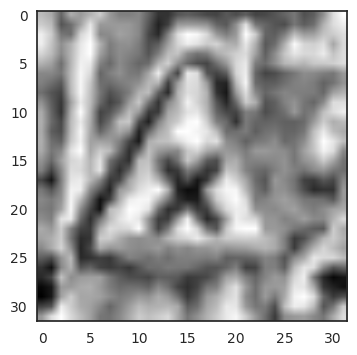

In [106]:
from PIL import Image


images = ["Training/00040/01826_00000.ppm"
          ,"Training/00000/01153_00001.ppm"
          ,"Training/00004/00282_00002.ppm"
          ,"Training/00019/00058_00001.ppm"
          ,"Training/00018/00009_00000.ppm"
         ]

for i in images:
    img = Image.open(i)
    img = img.resize((32, 32), Image.ANTIALIAS)
    print(np.shape(img))
    im_contrast,y = contrast_increase_data([np.asarray(img)],[1])
    print(np.shape(im_contrast[0]))
plt.imshow(im_contrast[0],cmap="gray")

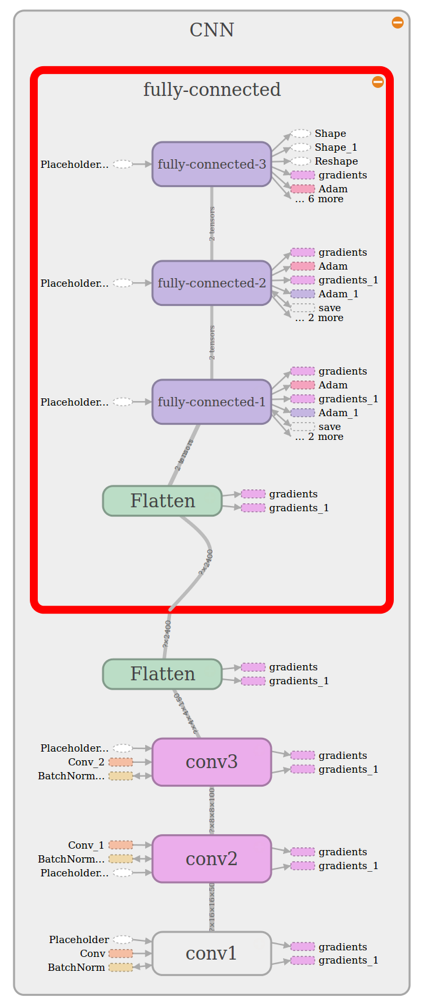

In [110]:
#What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) 
#For reference on how to build a deep neural network using TensorFlow, see Deep Neural Network in 
#TensorFlow from the classroom.
img = Image.open("./CNN_graph.png")
img

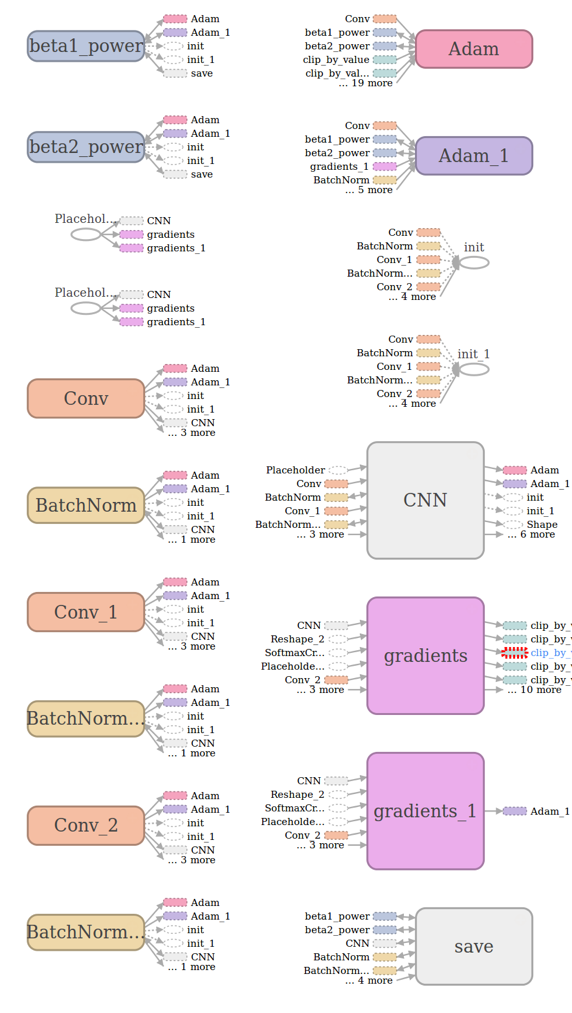

In [111]:
img = Image.open("./CNN_components.png")
img

In [2]:
from PIL import Image
import numpy as np


images = ["Training/00040/01826_00000.ppm"
          ,"Training/00000/01153_00001.ppm"
          ,"Training/00004/00282_00002.ppm"
          ,"Training/00019/00058_00001.ppm"
          ,"Training/00018/00009_00000.ppm"
          ,"Training/00032/00001_00002.ppm"
         ]
images_list =[]
for i in images:
    img = Image.open(i)
    img = img.resize((32, 32), Image.ANTIALIAS)
    images_list.append(img)

In [3]:
def image_resize(images):
    image_list = []
    for i in images:
        img = Image.open(i)
        img = img.resize((32, 32), Image.ANTIALIAS)
        image_list.append(img)
    return image_list



In [4]:

onlyfiles = [f for f in listdir("Training/*/") if isfile(join("Training", f))]

NameError: name 'listdir' is not defined

In [10]:
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
%matplotlib inline
def extra_data():
    training_dirs =[]
    l = []
    dirs = listdir("Training/")
    for each in dirs:
        if( not each.endswith("txt")):
            training_dirs.append(each)
    for each in training_dirs:
        dirs_inner = listdir("Training/"+each)
        for e in dirs_inner:
            if(e.endswith(".ppm")):
                l.append(join("Training",each,e)) 
    return l

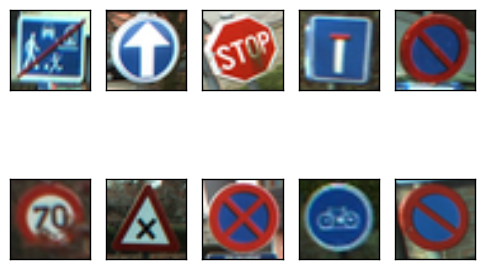

In [11]:
import random
l = extra_data()
ims = random.sample(l,10)
l_ims = image_resize(ims)

"""
Plots the images
"""
def plot_images(X,n_rows,n_cols ): 
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
    for i in range(n_rows):
        for j in range(n_cols) :
            ax1 = axes[i,j]
            #ax1 = plt.subplot(num_examples,num_var,k)
            ax1.imshow(X[n_cols*i+j])
            ax1.get_xaxis().set_ticks([])
            ax1.get_yaxis().set_ticks([])
    plt.show()
    fig.tight_layout()

plot_images(l_ims,2,5)

In [ ]:
print(np.shape(img))
        im_contrast,y = contrast_increase_data([np.asarray(img)],[1])
        print(np.shape(im_contrast[0]))
    plt.imshow(im_contrast[0],cmap="gray")